In [1]:
library(reshape2)
library(lubridate)
library(tseries)
library(MASS,stats)
library(car)
library(fGarch)
library(rugarch)

Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: carData

NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [2]:
data <- read.csv("SP500.csv")
head(data)

,caldt,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,20060103,0.016341,0.016340,0.015027,0.015023,11699545700,500,11540511600,500,1268.80,0.016430
2,20060104,0.003931,0.003736,0.006375,0.006284,11740829600,499,11697131300,499,1273.46,0.003673
3,20060105,0.000028,0.000021,0.000621,0.000611,11745619900,500,11745378700,500,1273.48,0.000016
4,20060106,0.009559,0.009322,0.010100,0.009988,11855262700,500,11745619900,500,1285.45,0.009399
5,20060109,0.003710,0.003708,0.005676,0.005673,11899300800,500,11855262700,500,1290.15,0.003656
6,20060110,-0.000340,-0.000394,0.000430,0.000379,11894617400,500,11899300800,500,1289.69,-0.000357


In [3]:
Ret <- data$sprtrn
y  <- as.matrix(Ret)
dates <- ymd(data$caldt)

In [4]:
n <- dim(y)[1]
# Initializing the EWMA matrix
EWMA <- matrix(NA, nrow = n, ncol = 3)
# Determine lambda
lambda <- 0.94

In [5]:
S <- cov(y)
S

0.0002766451


In [6]:
# Fill the initial row of EWMA with the sample covariances
EWMA[1,] <- S[upper.tri(S, diag = TRUE)]

# Manually computing EWMA elements for t = 2

# Apply the formula for EWMA
S_2 <- lambda * S + (1-lambda) * y[1,] %*% t(y[1,])
# Get the variances and covariances
S_2[upper.tri(S_2, diag = TRUE)]

# Populating the EWMA matrix

# Create a loop for rows 2 to n
for (i in 2:n) {
    # Update S with the new weighted moving average
    S <- lambda * S + (1-lambda) * y[i-1,] %*% t(y[i-1,])
    
    # Fill the following EWMA row with the covariances
    EWMA[i,] <- S[upper.tri(S, diag = TRUE)]
}

head(EWMA)

[1] 0.0002762431

0.0002766451,0.0002766451,0.0002766451
0.0002762431,0.0002762431,0.0002762431
0.0002604779,0.0002604779,0.0002604779
0.0002448493,0.0002448493,0.0002448493
0.0002354588,0.0002354588,0.0002354588
0.0002221332,0.0002221332,0.0002221332


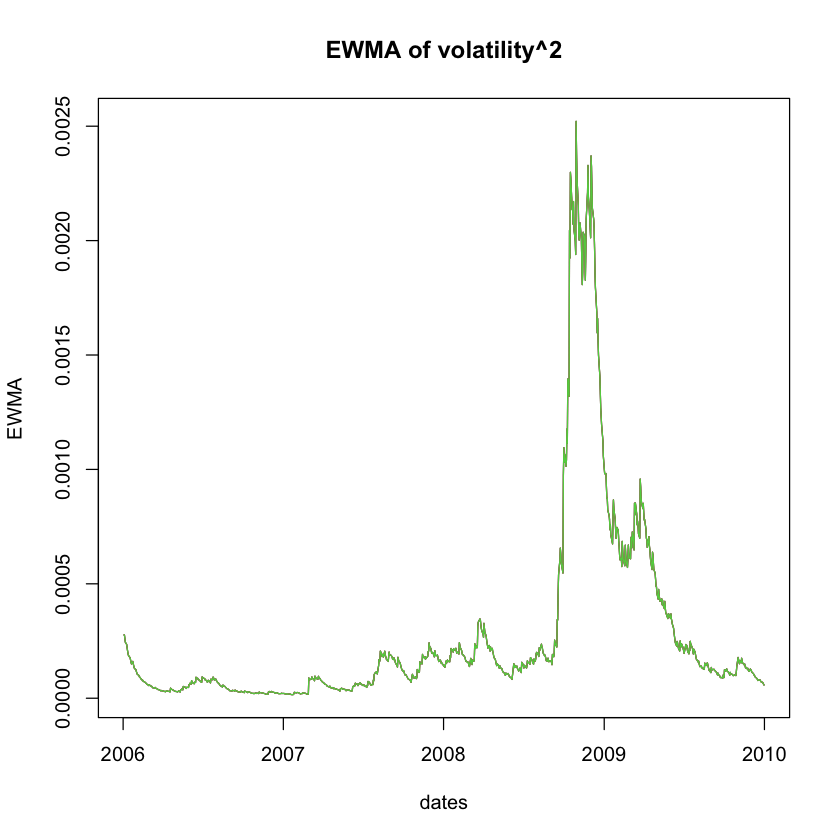

In [7]:
# Plotting estimated variances and covariances
matplot(dates, EWMA, type = "l", main = "EWMA of volatility^2", lty = 1)

In [8]:
# Implementing EWMA VaR

# Specifying the parameters for VaR
p <- 0.05
portfolio_value <- 1000

# Specifying the parameters for EWMA
lambda <- 0.94
n <- length(y)
BurnTime <- 30

# Vector to store estimated conditional volatility
EWMA_Variance <- rep(NA, length = n)

# First value is the sample variance
EWMA_Variance[1] <- var(y)

# See the vector
head(EWMA_Variance)

[1] 0.0002766451           NA           NA           NA           NA
[6]           NA

In [9]:
# Run the EWMA model using a for loop
for (i in 2:n) {
    EWMA_Variance[i] <- lambda * EWMA_Variance[i-1] + (1-lambda) * y[i-1]^2
}

In [10]:
# Replacing the data in the estimation window to NA
EWMA_Variance[1:BurnTime] <- NA

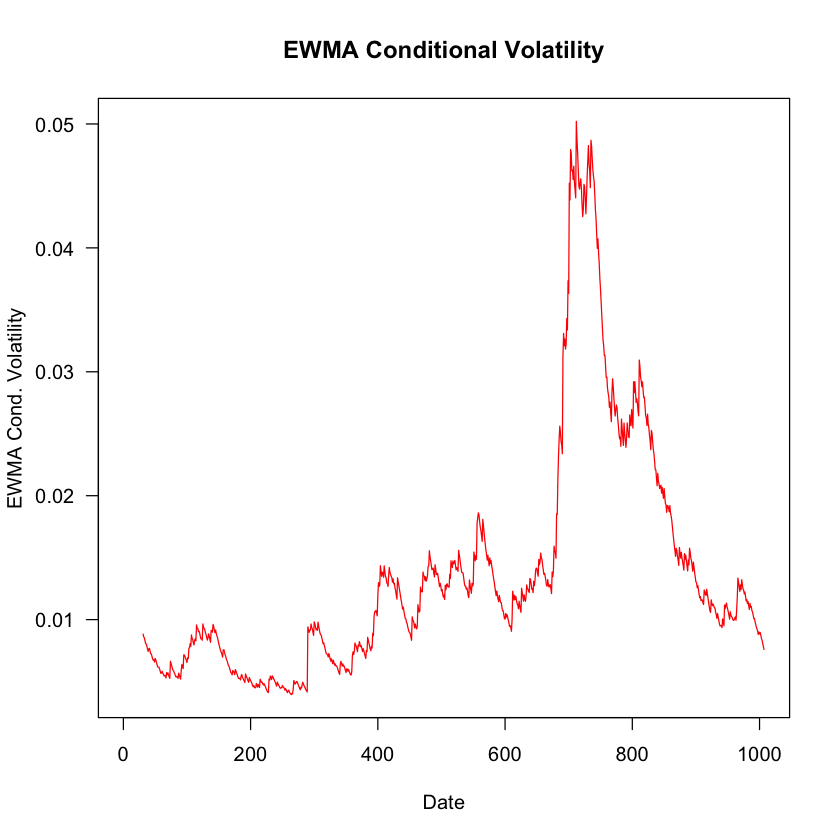

In [11]:
# Plot estimation for conditional volatility
EWMA_cond_volatility <- sqrt(EWMA_Variance)
plot(EWMA_cond_volatility, type = "l", main = "EWMA Conditional Volatility",
    las = 1, col = "red", xlab = "Date", ylab = "EWMA Cond. Volatility")

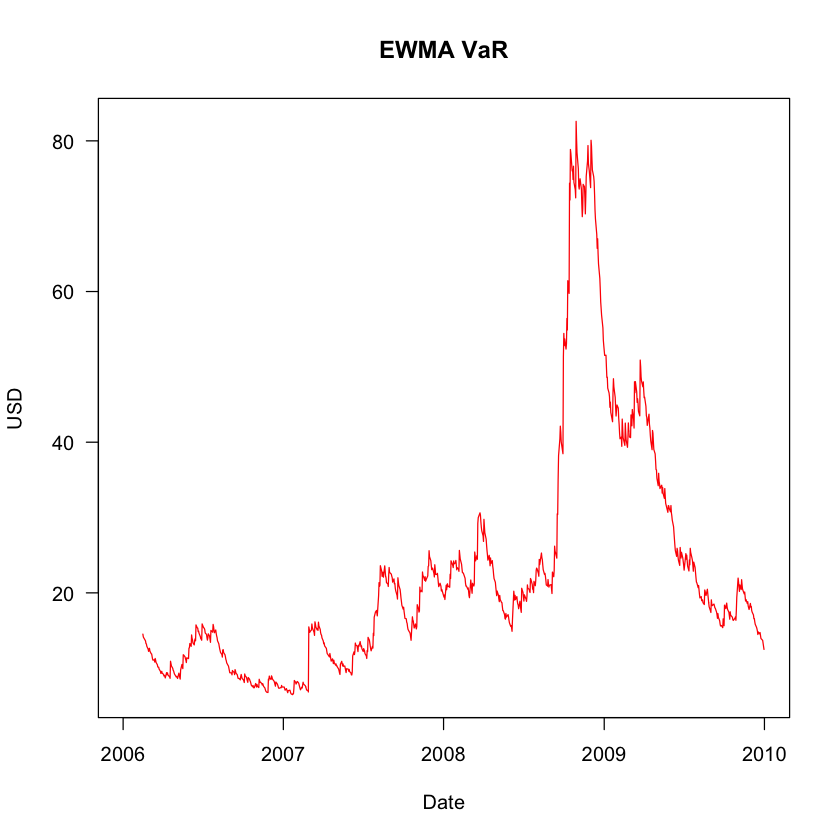

In [12]:
# Implementing the VaR forecast
EWMA_VaR <- -qnorm(p) * EWMA_cond_volatility * portfolio_value

# Plotting it
plot(dates, EWMA_VaR, type = "l", main = "EWMA VaR",
    las = 1, col = "red", xlab = "Date", ylab = "USD")

In [13]:
print(EWMA_VaR)

   [1]        NA        NA        NA        NA        NA        NA        NA
   [8]        NA        NA        NA        NA        NA        NA        NA
  [15]        NA        NA        NA        NA        NA        NA        NA
  [22]        NA        NA        NA        NA        NA        NA        NA
  [29]        NA        NA 14.525360 14.153446 14.036311 13.625134 13.275635
  [36] 13.222361 12.909466 12.526713 12.233181 12.579068 12.641883 12.274256
  [43] 11.915304 11.888555 11.550770 11.228714 11.062840 11.127015 10.817795
  [50] 11.293697 11.083977 10.770031 10.458738 10.162156 10.146255 10.131863
  [57]  9.878137  9.585395  9.302611  9.384806  9.583758  9.327585  9.198026
  [64]  8.965877  9.050915  8.945436  8.707389  9.414641  9.134240  9.388461
  [71]  9.115389  8.843226  8.655266 10.925617 10.616059 10.303403  9.989672
  [78]  9.734181  9.639452  9.414559  9.224198  8.947387  8.833346  8.914940
  [85]  8.798437  8.637406  9.345247  9.066723  8.791724  8.552278  9.764284

In [14]:
print(sqrt(var(Ret)))

[1] 0.01663265


## GARCH

In [15]:
data <- read.csv("SP500.csv")
head(data)

Ret <- data$sprtrn
y  <- as.matrix(Ret)
dates <- ymd(data$caldt)

# Parameters
portfolio_value = 1000
p = 0.05 #probability for VaR
probability = p

,caldt,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,20060103,0.016341,0.016340,0.015027,0.015023,11699545700,500,11540511600,500,1268.80,0.016430
2,20060104,0.003931,0.003736,0.006375,0.006284,11740829600,499,11697131300,499,1273.46,0.003673
3,20060105,0.000028,0.000021,0.000621,0.000611,11745619900,500,11745378700,500,1273.48,0.000016
4,20060106,0.009559,0.009322,0.010100,0.009988,11855262700,500,11745619900,500,1285.45,0.009399
5,20060109,0.003710,0.003708,0.005676,0.005673,11899300800,500,11855262700,500,1290.15,0.003656
6,20060110,-0.000340,-0.000394,0.000430,0.000379,11894617400,500,11899300800,500,1289.69,-0.000357


In [16]:
# Steps inside the function:
# Take as argument
# GARCH spec, here the default
# Probability, here 0.05
# Portfolio value, here 1000
# Estimation window, here 1000
spec <- ugarchspec()
p <- 0.05
portfolio_value <- 1000
WE <- 1000

# Determine number of observations
n <- length(y)

# Initialize empty VaR vector
    
VaR <- rep(NA, n)
    
# Do a loop for the forecast
for (i in 1:(n-WE)){
        
    # Subset the dataset to the estimation window
    window <- y[i:(i+WE-1)]
        
    # Fit the GARCH
    res <- ugarchfit(spec = spec, data = window, solver = "hybrid")
        
    # Save coefficients
    omega <- coef(res)['omega']
    alpha <- coef(res)['alpha1']
    beta <- coef(res)['beta1']
        
    # Estimate sigma2 using the last observation of window
    sigma2 <- omega + alpha*tail(window,1)^2 + beta*tail(res@fit$var,1)
        
    # Allocate the VaR forecast in the vector
    VaR[i+WE] <- -sqrt(sigma2) * qnorm(probability) * portfolio_value
    }

In [17]:
# Function that creates a GARCH forecast

DoGARCH <- function(y, spec, probability = p, portfolio_value = 1, WE = 1000){
    # GARCH function that takes as argument:
    # y: A vector of returns, ordered by date
    # spec: The ugarchspec object with the GARCH specification
    # probability: The probability to be used for VaR - Default 5%
    # portfolio_value: The portfolio value - Default 1
    # WE: Estimation window for the forecast - Default 1000 days
    
    # To calculate elapsed time, first get the current time
    old <- Sys.time()
    
    # Print message
    cat("Doing GARCH VaR forecast", "\n",
       "Estimation window:", WE, "\n",
       "Number of observations:", length(y), "\n",
       "VaR probability:", probability, "\n",
       "Portfolio value:", portfolio_value)
    
    # Number of observations
    n <- length(y)
    
    # Initialize empty VaR vector
    VaR <- rep(NA, n)
    
    # Do a loop for the forecast
    for (i in 1:(n-WE)){
        
        # Subset the dataset to the estimation window
        window <- y[i:(i+WE-1)]
        
        # Fit the GARCH
        res <- ugarchfit(spec = spec, data = window, solver = "hybrid")
        
        # Save coefficients
        omega <- coef(res)['omega']
        alpha <- coef(res)['alpha1']
        beta <- coef(res)['beta1']
        
        # Estimate sigma2 using the last observation of window
        sigma2 <- omega + alpha*tail(window,1)^2 + beta*tail(res@fit$var,1)
        
        # Allocate the VaR forecast in the vector
        VaR[i+WE] <- -sqrt(sigma2) * qnorm(probability) * portfolio_value
    }
    
    # Get the new time and print the elapsed time
    time <- difftime(Sys.time(), old, units = "secs")
    cat("\n", "Elapsed time:", round(time,4), "seconds")
    
    # Return the VaR vector
    return(VaR)
}

In [18]:
# Create specification
spec <- ugarchspec(
  variance.model = list(garchOrder= c(1,1)),
  mean.model = list(armaOrder = c(0,0), include.mean=FALSE)
)

In [19]:
# GARCH VaR for 200 days
GARCH200 <- DoGARCH(y, spec = spec, probability = p, portfolio_value = 1000, WE = 200)

Doing GARCH VaR forecast 
 Estimation window: 200 
 Number of observations: 1007 
 VaR probability: 0.05 
 Portfolio value: 1000
 Elapsed time: 39.8596 seconds

In [20]:
# GARCH VaR for 150 days
GARCH150 <- DoGARCH(y, spec = spec, probability = p, portfolio_value = 1000, WE = 150)

Doing GARCH VaR forecast 
 Estimation window: 150 
 Number of observations: 1007 
 VaR probability: 0.05 
 Portfolio value: 1000
 Elapsed time: 39.8891 seconds

In [21]:
# GARCH VaR for 100 days
GARCH100 <- DoGARCH(y, spec = spec, probability = p, portfolio_value = 1000, WE = 100)

Doing GARCH VaR forecast 
 Estimation window: 100 
 Number of observations: 1007 
 VaR probability: 0.05 
 Portfolio value: 1000
 Elapsed time: 40.864 seconds

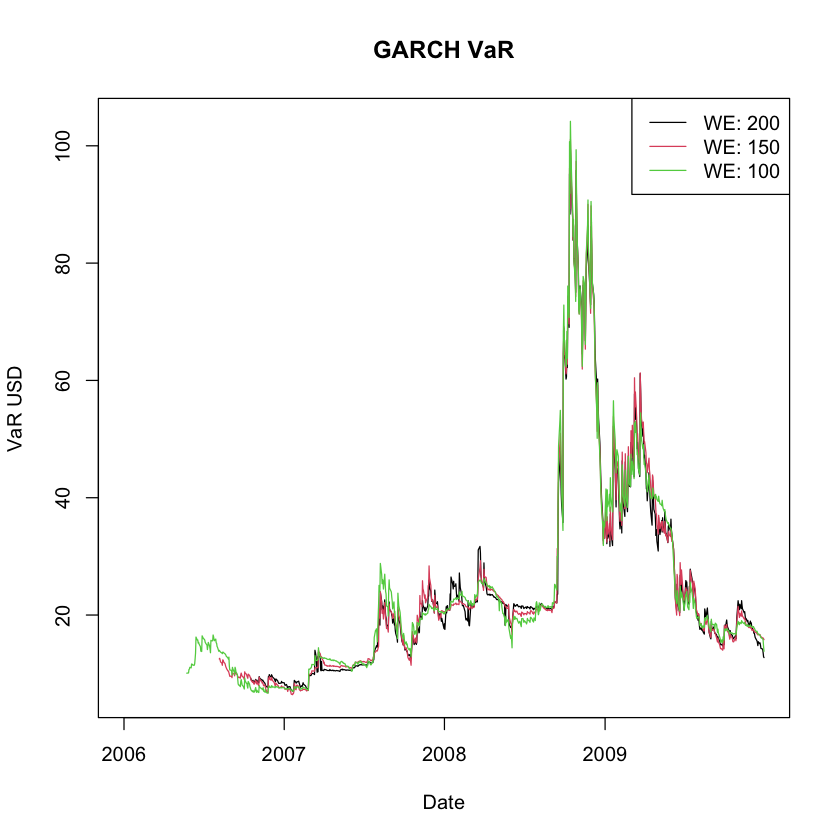

In [22]:
# Bind into a matrix
GARCH_VaR <- cbind(GARCH200, GARCH150, GARCH100)

# Plot and modify axis to include dates
matplot(dates, GARCH_VaR, type = "l", lty = 1, col = 1:3, xaxt = "n", main = "GARCH VaR", xlab = "Date", ylab = "VaR USD")
axis.Date(1, at = seq(min(dates), max(dates), by = "years"))

# Legend
legend("topright", legend = c("WE: 200", "WE: 150", "WE: 100"), lty = 1, col = 1:3)

In [23]:
VaR <- cbind(EWMA_VaR)

In [24]:
# Combining all VaR forecasts
# VaR is load from .RData file includes VaR for HS300, HS1000, HS2000 and EWMA
VaR <- cbind(VaR, GARCH200, GARCH150, GARCH100)

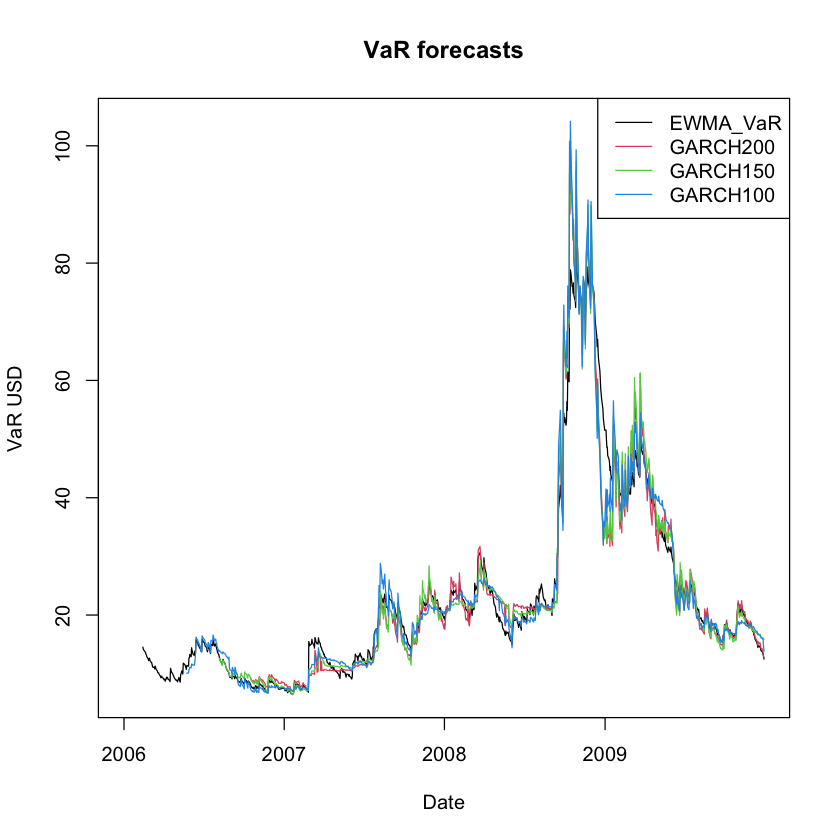

In [25]:
# Plot all
matplot(dates, VaR, type = "l", lty = 1, col = 1:7, xaxt = "n", main = "VaR forecasts", xlab = "Date", ylab = "VaR USD")
axis.Date(1, at = seq(min(dates), max(dates), by = "years"))

# Legend
legend("topright", legend = colnames(VaR), lty = 1, col = 1:7)

## backtesting

In [26]:
# Means for each forecast
round(colMeans(VaR, na.rm = TRUE),3)

# Standard deviations - We
round(apply(VaR, MARGIN = 2, sd, na.rm = TRUE))

EWMA_VaR GARCH200 GARCH150 GARCH100 
  22.626   24.826   24.173   23.745

EWMA_VaR GARCH200 GARCH150 GARCH100 
      16       17       17       17

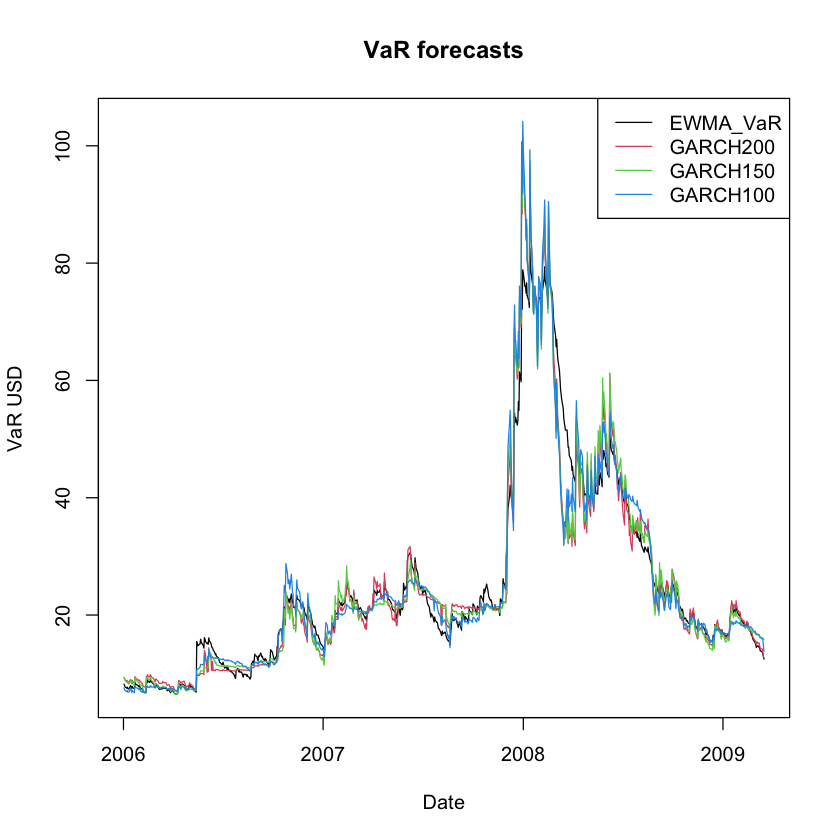

In [27]:
# Find maximum estimation window
windows <- colSums(is.na(VaR))

#restrict to largest estimation window
start <- max(windows) + 1
end <- length(dates)

# Plot all
matplot(dates[start:end], VaR[start:end,], type = "l", lty = 1, col = 1:6, xaxt = "n",
        main = "VaR forecasts", xlab = "Date", ylab = "VaR USD")
axis.Date(1, at = seq(dates[max(windows)], max(dates), by = "years"))

# Legend
legend("topright", legend = colnames(VaR), lty = 1, col = 1:6)

In [28]:
# Backtesting and Violation Ratios

# Let's transform VaR to a data.frame
VaR <- as.data.frame(VaR)

# Initialize a Violations data.frame, same dim and colnames as VaR, fill with NA
Violations <- VaR
Violations[] <- NA

dim(Violations)

[1] 1007    4

In [29]:
# Populating the Violations matrix

# For every model (columns in VaR) restricted to largest estimation window
for(i in 1:dim(VaR)[2]){
    
    # Fill the column in Violations with TRUE/FALSE
    # TRUE if the realized return is lower than VaR
    # FALSE otherwise
    Violations[,i] <- (y*portfolio_value < -VaR[,i])
}

# Restrict to largest estimation window
Violations[1:(start-1),] <- NA

In [30]:
# Find where violations happened
dates[which(Violations$EWMA_VaR)]

[1] "2006-10-27" "2006-11-27" "2007-01-25" "2007-02-27" "2007-03-13"
 [6] "2007-05-10" "2007-05-24" "2007-06-07" "2007-06-20" "2007-06-22"
[11] "2007-07-10" "2007-07-24" "2007-07-26" "2007-08-03" "2007-08-09"
[16] "2007-08-28" "2007-10-19" "2007-11-01" "2007-11-07" "2007-11-26"
[21] "2007-12-11" "2008-01-04" "2008-01-15" "2008-01-17" "2008-02-05"
[26] "2008-02-29" "2008-03-06" "2008-06-06" "2008-06-20" "2008-06-26"
[31] "2008-07-09" "2008-07-24" "2008-09-04" "2008-09-09" "2008-09-15"
[36] "2008-09-17" "2008-09-29" "2008-10-07" "2008-10-09" "2008-10-15"
[41] "2008-12-01" "2009-01-20" "2009-02-10" "2009-02-17" "2009-03-02"
[46] "2009-03-05" "2009-04-20" "2009-06-22" "2009-07-02" "2009-08-17"
[51] "2009-09-01" "2009-10-01" "2009-10-28" "2009-10-30"

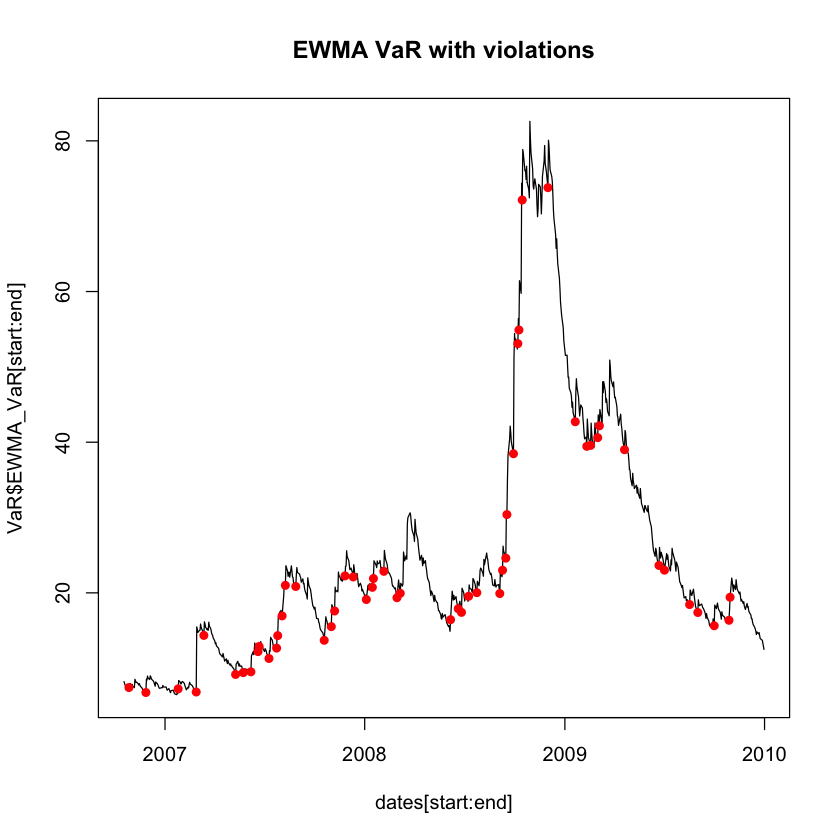

In [31]:
# Plotting the violations
plot(dates[start:end], VaR$EWMA_VaR[start:end], type = "l", main = "EWMA VaR with violations",)

# Add points where the violations happened
points(dates[Violations$EWMA_VaR], VaR$EWMA_VaR[Violations$EWMA_VaR], pch = 16, col = "red")

In [32]:
# Check dates where all models have a violation
# restrict to largest estimation window
w <- apply(Violations, 1, all)

In [33]:
# Days where all models have a violation
# na.rm =TRUE means we will firstly remove all NA elements
sum(w, na.rm = TRUE)

[1] 48

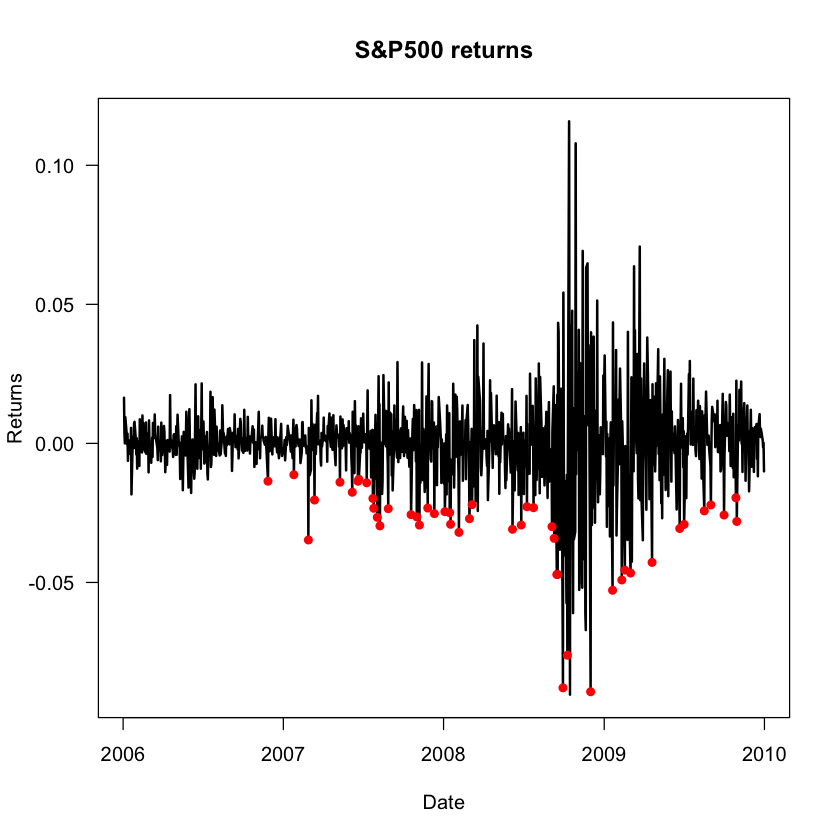

In [34]:
# Plotting the returns and adding the days where all models had a violation
plot(dates, y, main = "S&P500 returns", type = "l", lwd = 2, las = 1,
    xlab = "Date", ylab = "Returns")
points(dates[w], y[w], pch = 16, col = "red")

In [35]:
# Counting Violations by model
colSums(Violations, na.rm = TRUE)

EWMA_VaR GARCH200 GARCH150 GARCH100 
      54       54       56       53

In [36]:
# Creating a Violation Ratio object

# Remove the rows with NA
Violations <- Violations[!is.na(Violations[,2]),]

# Get the column sums
V <- colSums(Violations)

# Calculate expected violations
EV <- dim(Violations)[1]*p

# Violation Ratios
VR <- V/EV

# Call object, rounding to 3 decimals
round(VR,3)

EWMA_VaR GARCH200 GARCH150 GARCH100 
   1.338    1.338    1.388    1.314

In [37]:
# We can write a function that uses our rule of thumb to assess the model
model_assessment <- function(VR) {
    if (VR > 0.8 & VR < 1.2) {
        paste0(names(VR), "Model is good")
    } else if ((VR > 0.5 & VR <= 0.8) | (VR > 1.2 & VR <= 1.5)) {
        paste0(names(VR), "Model is acceptable")
    } else if ((VR > 0.3 & VR <= 0.5) | (VR > 1.5 & VR <= 2)) {
        paste0(names(VR), "Model is bad")
    } else {
        paste0(names(VR), "Model is useless")
    }
}

In [38]:
# We can use sapply(), the vector version of apply()
sapply(VR, model_assessment)

EWMA_VaR              GARCH200              GARCH150 
"Model is acceptable" "Model is acceptable" "Model is acceptable" 
             GARCH100 
"Model is acceptable"

In [39]:
# Best performing - VR closest to 1
sort(round(abs(VR-1),3))

GARCH100 EWMA_VaR GARCH200 GARCH150 
   0.314    0.338    0.338    0.388